In [34]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import os

In [2]:
df = pd.read_csv('predictive_maintenance.csv')
print(df.shape)
print(df.columns)
print(df[['Target', 'Failure Type']].apply(pd.Series.nunique))

(10000, 10)
Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')
Target          2
Failure Type    6
dtype: int64


In [3]:
print("Class distribution (Failure):")
print(df['Target'].value_counts(normalize=True))
print("\nClass distribution (Failure Type):")
print(df['Failure Type'].value_counts(normalize=True))

Class distribution (Failure):
Target
0    0.9661
1    0.0339
Name: proportion, dtype: float64

Class distribution (Failure Type):
Failure Type
No Failure                  0.9652
Heat Dissipation Failure    0.0112
Power Failure               0.0095
Overstrain Failure          0.0078
Tool Wear Failure           0.0045
Random Failures             0.0018
Name: proportion, dtype: float64


In [4]:
display(df.head())

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [5]:
if 'UID' in df.columns:
    df = df.drop(columns=['UID'])

In [6]:
target_bin = 'Target'
target_multi = 'Failure Type'

In [7]:
le = LabelEncoder()
df[target_multi] = le.fit_transform(df[target_multi])
print("Failure Type classes:", le.classes_)

Failure Type classes: ['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Random Failures' 'Tool Wear Failure']


In [8]:
cat_cols = ['Product ID', 'Type']
num_cols = [c for c in df.columns if c not in cat_cols + [target_bin, target_multi]]


In [9]:
df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, drop_first=False)

In [10]:
X = df.drop(columns=[target_bin, target_multi]).copy()
y_bin = df[target_bin].values
y_multi = df[target_multi].values

In [11]:
X_train, X_temp, y_bin_train, y_bin_temp, y_multi_train, y_multi_temp = train_test_split(
    X, y_bin, y_multi,
    test_size=0.3,
    random_state=42,
    stratify=y_multi
)

In [12]:
X_val, X_test, y_bin_val, y_bin_test, y_multi_val, y_multi_test = train_test_split(
    X_temp, y_bin_temp, y_multi_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_multi_temp
)

In [13]:
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Train: (7000, 10009)
Val: (1500, 10009)
Test: (1500, 10009)


In [14]:
numeric_cols = [c for c in X_train.columns if X_train[c].dtype.kind in 'bifc']

In [15]:
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols]   = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

In [16]:
sm = SMOTE(random_state=42)
X_res, y_multi_res = sm.fit_resample(X_train, y_multi_train)

In [17]:
y_bin_res = (y_multi_res != 0).astype(int)

In [18]:
print("After SMOTE, new training shape:", X_res.shape)
print("New multiclass distribution:", np.bincount(y_multi_res))

After SMOTE, new training shape: (40536, 10009)
New multiclass distribution: [6756 6756 6756 6756 6756 6756]


In [19]:
class TabularDataset(Dataset):
    def __init__(self, X, y_bin, y_multi):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y_bin = torch.tensor(y_bin, dtype=torch.long)
        self.y_multi = torch.tensor(y_multi, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_bin[idx], self.y_multi[idx]

In [20]:
train_ds = TabularDataset(X_res, y_bin_res, y_multi_res)
val_ds   = TabularDataset(X_val, y_bin_val, y_multi_val)
test_ds  = TabularDataset(X_test, y_bin_test, y_multi_test)

In [21]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [24]:
# Input dimension (number of features)
input_dim = train_loader.dataset.X.shape[1]

# Number of classes in the multiclass target
n_multi_classes = int(train_loader.dataset.y_multi.max().item() + 1)

print("Input dim:", input_dim)
print("Multiclass classes:", n_multi_classes)


Input dim: 10009
Multiclass classes: 6


In [25]:
try:
    input_dim
except NameError:
    # infer from train_loader dataset
    input_dim = train_loader.dataset.X.shape[1]
try:
    n_multi_classes
except NameError:
    n_multi_classes = int(np.max(train_loader.dataset.y_multi).item()) + 1

print("Input dim:", input_dim, "Multi classes:", n_multi_classes)

Input dim: 10009 Multi classes: 6


In [26]:
class MultiTaskNet(nn.Module):
    def __init__(self, input_dim, hidden=[256,128], dropout=0.3, use_bn=True):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            if use_bn:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev = h
        self.shared = nn.Sequential(*layers)
        # binary head
        self.bin_head = nn.Sequential(
            nn.Linear(prev, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )
        # multi head
        self.multi_head = nn.Sequential(
            nn.Linear(prev, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, n_multi_classes)
        )
    def forward(self, x):
        s = self.shared(x)
        out_bin = self.bin_head(s)
        out_multi = self.multi_head(s)
        return out_bin, out_multi

In [27]:
from sklearn.utils.class_weight import compute_class_weight

try:
    base_y_multi = y_multi_train  # from earlier split
except NameError:
    base_y_multi = np.concatenate([batch[2].numpy() for batch in train_loader])  # fallback

classes = np.unique(base_y_multi)
class_weights_multi = compute_class_weight('balanced', classes=classes, y=base_y_multi)
class_weights_multi = torch.tensor(class_weights_multi, dtype=torch.float32).to(device)
print("Multiclass class weights:", class_weights_multi.cpu().numpy())

Multiclass class weights: [14.957265    0.17268601 21.212122   17.412935   89.74359    37.634407  ]


In [28]:
try:
    base_y_bin = y_bin_train
except NameError:
    base_y_bin = np.concatenate([batch[1].numpy() for batch in train_loader])
bin_classes = np.unique(base_y_bin)
class_weights_bin = compute_class_weight('balanced', classes=bin_classes, y=base_y_bin)
class_weights_bin = torch.tensor(class_weights_bin, dtype=torch.float32).to(device)
print("Binary class weights:", class_weights_bin.cpu().numpy())

model = MultiTaskNet(input_dim=input_dim, hidden=[256,128], dropout=0.25, use_bn=True).to(device)

criterion_bin = nn.CrossEntropyLoss(weight=class_weights_bin)
criterion_multi = nn.CrossEntropyLoss(weight=class_weights_multi)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Binary class weights: [ 0.51775146 14.583333  ]


In [29]:
def train_one_epoch(model, loader, opt, crit_bin, crit_multi, device, lambda_multi=1.0):
    model.train()
    running_loss = 0.0
    total = 0
    correct_bin = 0
    for Xb, yb_bin, yb_multi in loader:
        Xb = Xb.to(device); yb_bin = yb_bin.to(device); yb_multi = yb_multi.to(device)
        opt.zero_grad()
        out_bin, out_multi = model(Xb)
        loss_bin = crit_bin(out_bin, yb_bin)
        loss_multi = crit_multi(out_multi, yb_multi)
        loss = loss_bin + lambda_multiple*loss_multi if (lambda_multiple := 1.0) else loss_bin + loss_multi
        loss.backward()
        opt.step()
        running_loss += loss.item() * Xb.size(0)
        preds_bin = out_bin.argmax(dim=1)
        correct_bin += (preds_bin == yb_bin).sum().item()
        total += Xb.size(0)
    return running_loss / total, correct_bin / total

In [30]:
def evaluate(model, loader, crit_bin, crit_multi, device, lambda_multi=1.0):
    model.eval()
    running_loss = 0.0
    all_bin_true = []; all_bin_pred = []
    all_multi_true = []; all_multi_pred = []
    total = 0
    for Xb, yb_bin, yb_multi in loader:
        Xb = Xb.to(device); yb_bin = yb_bin.to(device); yb_multi = yb_multi.to(device)
        out_bin, out_multi = model(Xb)
        loss_bin = crit_bin(out_bin, yb_bin)
        loss_multi = crit_multi(out_multi, yb_multi)
        loss = loss_bin + lambda_multi*loss_multi
        running_loss += loss.item() * Xb.size(0)
        bp = out_bin.argmax(dim=1).cpu().numpy()
        mp = out_multi.argmax(dim=1).cpu().numpy()
        all_bin_pred.append(bp); all_bin_true.append(yb_bin.cpu().numpy())
        all_multi_pred.append(mp); all_multi_true.append(yb_multi.cpu().numpy())
        total += Xb.size(0)
    all_bin_pred = np.concatenate(all_bin_pred); all_bin_true = np.concatenate(all_bin_true)
    all_multi_pred = np.concatenate(all_multi_pred); all_multi_true = np.concatenate(all_multi_true)
    acc_bin = (all_bin_pred == all_bin_true).mean()
    acc_multi = (all_multi_pred == all_multi_true).mean()
    return running_loss/total, acc_bin, acc_multi, all_bin_true, all_bin_pred, all_multi_true, all_multi_pred


In [31]:
n_epochs = 60
patience = 8
best_val = -np.inf
epochs_no_improve = 0
history = {'train_loss':[], 'val_loss':[], 'train_acc_bin':[], 'val_acc_bin':[], 'val_acc_multi':[]}

In [32]:
for ep in range(1, n_epochs+1):
    tr_loss, tr_acc_bin = train_one_epoch(model, train_loader, optimizer, criterion_bin, criterion_multi, device, lambda_multi=1.0)
    val_loss, val_acc_bin, val_acc_multi, *_ = evaluate(model, val_loader, criterion_bin, criterion_multi, device, lambda_multi=1.0)

    history['train_loss'].append(tr_loss); history['val_loss'].append(val_loss)
    history['train_acc_bin'].append(tr_acc_bin); history['val_acc_bin'].append(val_acc_bin); history['val_acc_multi'].append(val_acc_multi)

    print(f"Epoch {ep:02d} | tr_loss {tr_loss:.4f} tr_acc_bin {tr_acc_bin:.4f} | val_loss {val_loss:.4f} val_acc_bin {val_acc_bin:.4f} val_acc_multi {val_acc_multi:.4f}")

    # checkpoint on validation multiclass accuracy (primary interest)
    if val_acc_multi > best_val + 1e-6:
        best_val = val_acc_multi
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_multitask_model.pt")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered. No improvement for", patience, "epochs.")
        break

# Load best model
model.load_state_dict(torch.load("best_multitask_model.pt"))

Epoch 01 | tr_loss 0.1885 tr_acc_bin 0.8731 | val_loss 5.6637 val_acc_bin 0.0327 val_acc_multi 0.0033
Epoch 02 | tr_loss 0.0045 tr_acc_bin 0.9987 | val_loss 8.3806 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 03 | tr_loss 0.0013 tr_acc_bin 0.9998 | val_loss 11.4145 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 04 | tr_loss 0.0006 tr_acc_bin 0.9999 | val_loss 12.6887 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 05 | tr_loss 0.0004 tr_acc_bin 1.0000 | val_loss 12.6542 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 06 | tr_loss 0.0003 tr_acc_bin 1.0000 | val_loss 13.1542 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 07 | tr_loss 0.0002 tr_acc_bin 1.0000 | val_loss 13.5591 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 08 | tr_loss 0.0001 tr_acc_bin 1.0000 | val_loss 13.5620 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 09 | tr_loss 0.0001 tr_acc_bin 1.0000 | val_loss 13.7031 val_acc_bin 0.0327 val_acc_multi 0.9653
Epoch 10 | tr_loss 0.0001 tr_acc_bin 1.0000 | val_loss 14.1706 val_acc_bin 

<All keys matched successfully>

In [33]:
test_loss, test_acc_bin, test_acc_multi, bin_true, bin_pred, multi_true, multi_pred = evaluate(
    model, test_loader, criterion_bin, criterion_multi, device, lambda_multi=1.0)

print("\n== Test results ==")
print("Test loss:", test_loss)
print("Binary acc:", test_acc_bin)
print("Multi acc:", test_acc_multi)
print("\nBinary classification report:")
print(classification_report(bin_true, bin_pred, digits=4))
print("\nMulti-class classification report:")
print(classification_report(multi_true, multi_pred, digits=4))



== Test results ==
Test loss: 8.398442286173502
Binary acc: 0.03333333333333333
Multi acc: 0.9653333333333334

Binary classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1450
           1     0.0333    1.0000    0.0645        50

    accuracy                         0.0333      1500
   macro avg     0.0167    0.5000    0.0323      1500
weighted avg     0.0011    0.0333    0.0022      1500


Multi-class classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        17
           1     0.9653    1.0000    0.9824      1448
           2     0.0000    0.0000    0.0000        12
           3     0.0000    0.0000    0.0000        14
           4     0.0000    0.0000    0.0000         2
           5     0.0000    0.0000    0.0000         7

    accuracy                         0.9653      1500
   macro avg     0.1609    0.1667    0.1637      1500
weighte

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

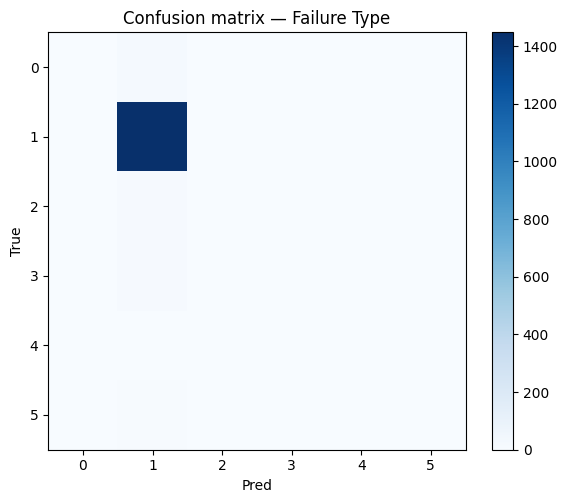

In [34]:
plt.figure(figsize=(6,5))
cm = confusion_matrix(multi_true, multi_pred)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion matrix — Failure Type")
plt.colorbar(); plt.ylabel('True'); plt.xlabel('Pred')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Loss / epoch')

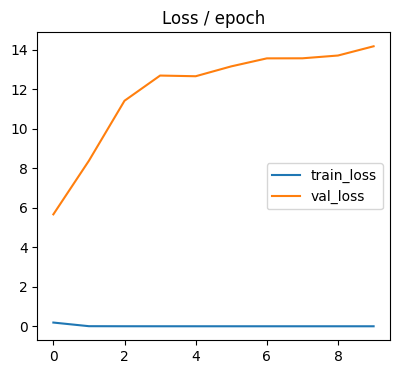

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss / epoch')

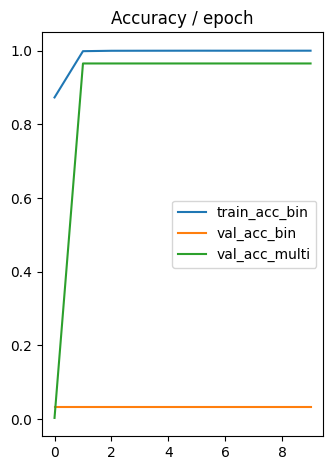

In [36]:
plt.subplot(1,2,2)
plt.plot(history['train_acc_bin'], label='train_acc_bin')
plt.plot(history['val_acc_bin'], label='val_acc_bin')
plt.plot(history['val_acc_multi'], label='val_acc_multi')
plt.legend(); plt.title('Accuracy / epoch')
plt.tight_layout()
plt.show()